In [26]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import itertools

import tensorflow as tf

from keras.layers import Dropout
from keras import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [27]:
folder = 'Imagens'
#mudei essas linhas de baixo pois estava em 120
image_width = 64
image_height = 64
channels = 3

train_files = []
i=0
for coin in ['5', '10', '25', '50', '100']:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(coin)) if os.path.isfile(os.path.join(folder + '/' + str(coin), f))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels), dtype=np.float32)
y_dataset = []

i = 0
for coin in ['5', '10', '25', '50', '100']:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(coin)) if os.path.isfile(os.path.join(folder + '/' + str(coin), f))]
    for _file in onlyfiles:
  ###
        img = cv2.imread(os.path.join(folder, coin, _file))
        img_resized = cv2.resize(img, (image_width, image_height))

        dataset[i] = img_resized
        mapping = {'5': 0, '10': 1, '25': 2, '50': 3, '100': 4, }
        y_dataset.append(mapping[coin])
   ###

        i += 1
        if i % 250 == 0:
            print("%d images to array" % i)
print("All images to array!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
All images to array!


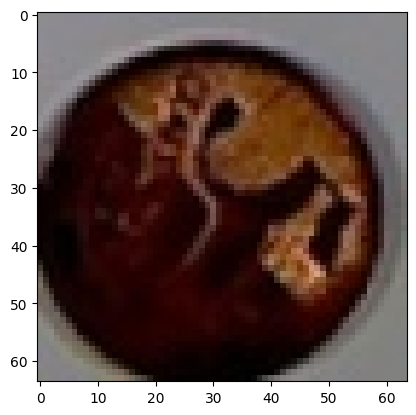

5


In [28]:
# normalizando os dados
dataset = dataset.astype('float32')
dataset /= 255

pixels = np.array(dataset[0], dtype='float32')
plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB))
plt.show()
plt.close()
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y_dataset_, test_size=0.2)
print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 1080, Test set size: 270


In [30]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=90, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

datagen.fit(X_train)


In [31]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=(64, 64, 3)))
model.add(tf.keras.layers.Conv2D(filters= 128, kernel_size=(5, 5), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters= 64, kernel_size=(3, 3), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters= 32, kernel_size=(2, 2), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 256, activation='relu'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(units = 5, activation='softmax', name = 'saida'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Bat  (None, 64, 64, 3)         12        
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 128)       9728      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)       

In [32]:
#taxa de aprendizado
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

#compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [33]:
#parada antecipada
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 5)

#treinando o modelo
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks = [early_stopping])


Epoch 1/100
27/27 [==============================] - 41s 1s/step - loss: 1.2708 - accuracy: 0.4919 - val_loss: 1.4426 - val_accuracy: 0.2917
Epoch 2/100
27/27 [==============================] - 37s 1s/step - loss: 0.7617 - accuracy: 0.7257 - val_loss: 1.1517 - val_accuracy: 0.6806
Epoch 3/100
27/27 [==============================] - 39s 1s/step - loss: 0.5707 - accuracy: 0.7928 - val_loss: 0.9485 - val_accuracy: 0.7778
Epoch 4/100
27/27 [==============================] - 37s 1s/step - loss: 0.4899 - accuracy: 0.8264 - val_loss: 0.7098 - val_accuracy: 0.8287
Epoch 5/100
27/27 [==============================] - 36s 1s/step - loss: 0.4756 - accuracy: 0.8183 - val_loss: 0.9055 - val_accuracy: 0.7639
Epoch 6/100
27/27 [==============================] - 37s 1s/step - loss: 0.3864 - accuracy: 0.8669 - val_loss: 0.5423 - val_accuracy: 0.8565


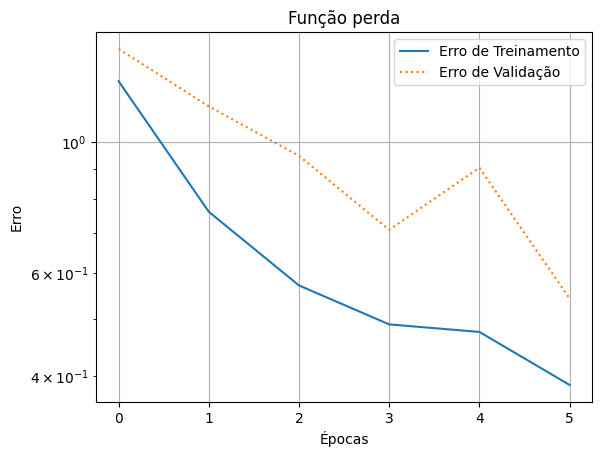

In [34]:
# Gráfico de treinamento e validação da função perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], ':')
plt.title('Função perda')
plt.yscale('log')
plt.ylabel('Erro')
plt.xlabel('Épocas')
plt.legend(['Erro de Treinamento', 'Erro de Validação'])
plt.grid(True)
plt.show()

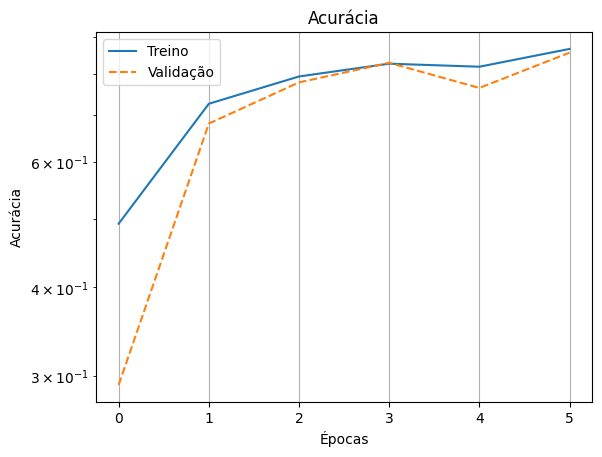

In [35]:
# Plotando o treinamento e a validação da accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '--')
plt.yscale("log")
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'])
plt.grid(True)
plt.show()

In [36]:
preds = model.predict(X_test)

9/9 [==============================] - 4s 375ms/step


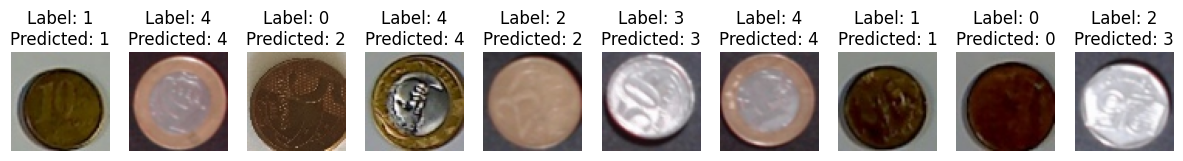

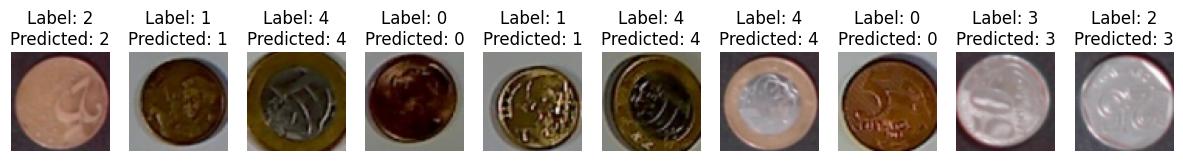

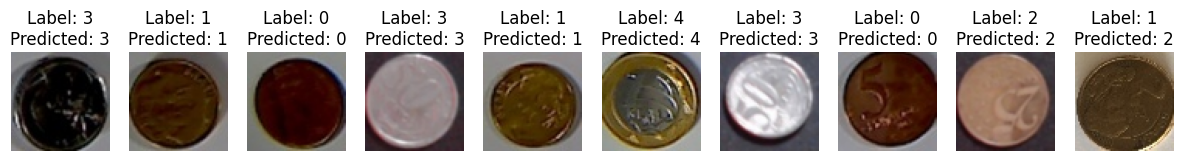

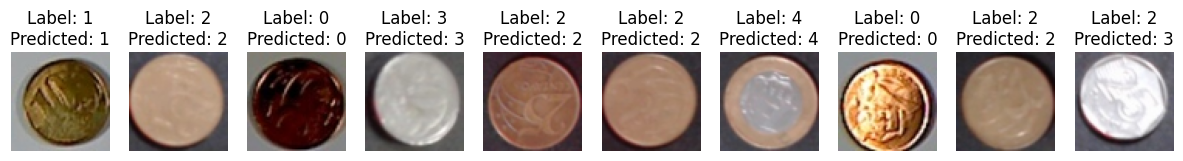

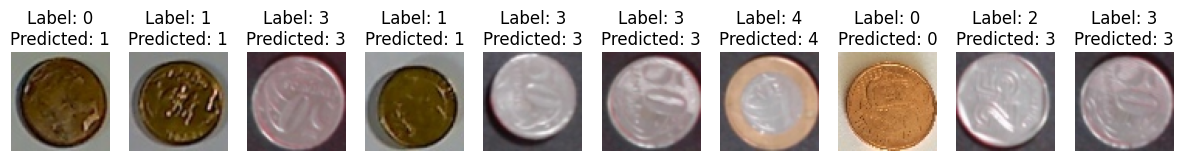

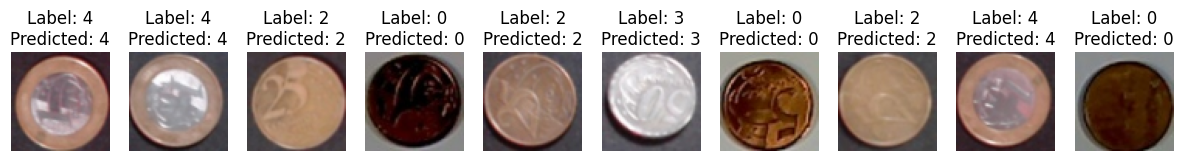

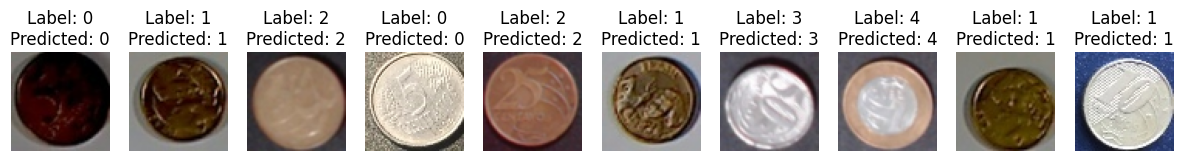

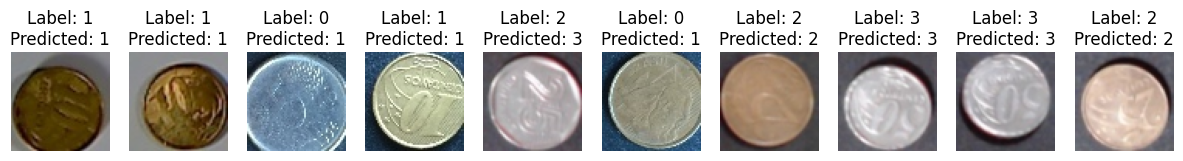

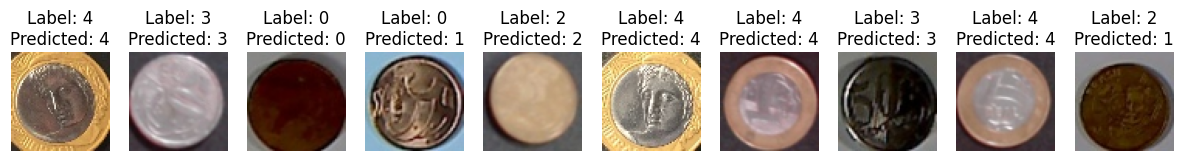

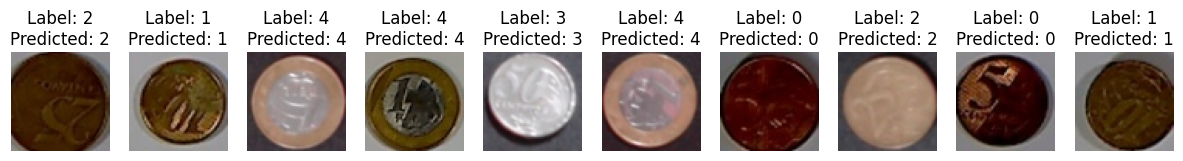

In [37]:
n = 10
for t in range(10):
    plt.figure(figsize=(15,15))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Label: {}\nPredicted: {}'.format(np.argmax(y_test[i]), np.argmax(preds[i])))
        plt.axis('off')
    plt.show()

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

Confusion matrix, without normalization
[[41 10  1  2  0]
 [ 1 44  3  1  0]
 [ 2  4 38 13  0]
 [ 2  1  0 51  0]
 [ 0  0  0  0 56]]


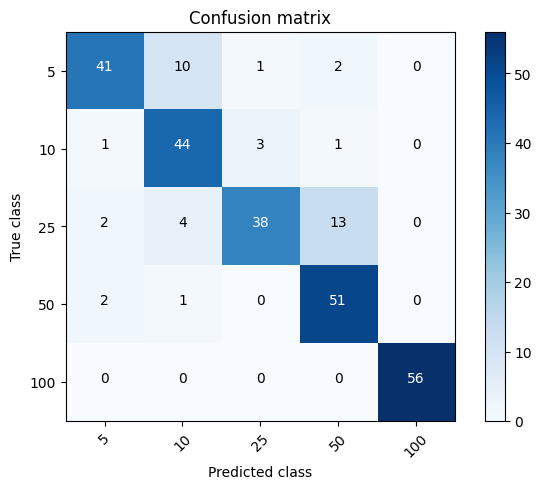

In [39]:
# Plot non-normalized confusion matrix
#y_test_ = np.apply_along_axis(np.argmax, 1, y_test)
#preds_ = np.apply_along_axis(np.argmax, 1, preds)
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plt.figure()
plot_confusion_matrix(cm, classes=['5', '10', '25', '50', '100'], title='Confusion matrix')
plt.show()

In [40]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: {:.2f}%".format(accuracy * 100))

9/9 [==============================] - 3s 327ms/step - loss: 0.5492 - accuracy: 0.8519
Loss:  0.5491988658905029
Accuracy: 85.19%


In [41]:
# Convertendo as previsões e os rótulos de volta para as classes originais
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]


In [42]:
# Calcular acurácia
accuracy = accuracy_score(y_test_, preds_)
print("Acurácia:", accuracy)

Acurácia: 0.8518518518518519


In [43]:
# Calcular precisão
precision = precision_score(y_test_, preds_, average='macro')
print("Precisão:", precision)

Precisão: 0.860604598860629


In [44]:
# Calcular recall
recall = recall_score(y_test_, preds_, average='macro')
print("Recall:", recall)

Recall: 0.853665910808768


In [45]:
# Calcular F1 score
f1 = f1_score(y_test_, preds_, average='macro')
print("F1-score:", f1)

F1-score: 0.8490933578206306


In [46]:
# Testando o modelo
teste_image_path = 'moeda.jpg'  # Substitua pelo caminho da sua imagem de teste
teste_image = tf.keras.preprocessing.image.load_img(teste_image_path, target_size=(64, 64))
teste_image_array = tf.keras.preprocessing.image.img_to_array(teste_image)
teste_image_array = np.expand_dims(teste_image_array, axis=0)  # Adiciona uma dimensão para representar o lote (batch)

# Predição
saida_predita = model.predict(teste_image_array)

print('Saída Preditada:', saida_predita)


1/1 [==============================] - 0s 60ms/step
Saída Preditada: [[0. 1. 0. 0. 0.]]


In [47]:
# Mapeamento de números de classe para nomes de classe
class_name = {
    0: "Moeda de 5 centavos",
    1: "Moeda de 10 centavos",
    2: "Moeda de 25 centavos",
    3: "Moeda de 50 centavos",
    4: "Moeda de 1 real"
}

# Obtém o número da classe prevista
classe_prevista = np.argmax(saida_predita)

# Obtém o nome da classe prevista usando o mapeamento
nome_classe_prevista = class_name[classe_prevista]

print('Classe Prevista:', nome_classe_prevista)

Classe Prevista: Moeda de 10 centavos


In [48]:
# saving model
#model.save('mode_acurracy87.h5')

c:\Users\BRUNO WELL\Desktop\contador de moedas real\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
#dados = pd.DataFrame(history.history)
#dados.head()

In [50]:
#dados.to_csv('loss.csv')